In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

In [12]:
#Data Loading
# set root as images folder path of dataset
root ="/content/drive/MyDrive/Colab_Notebooks/Kidneystone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# read dataset
base_dir = os.path.join(root)
cyst_dir = os.path.join(base_dir,'Cyst')
normal_dir = os.path.join(base_dir,'Normal')
stone_dir = os.path.join(base_dir,'Stone')
tumor_dir = os.path.join(base_dir,'Tumor')

cyst_files = glob.glob(cyst_dir+'/*.jpg')
normal_files = glob.glob(normal_dir+'/*.jpg')
stone_files = glob.glob(stone_dir+'/*.jpg')
tumor_files = glob.glob(tumor_dir+'/*.jpg')

len(cyst_files), len(normal_files),len(stone_files), len(tumor_files) 

(3728, 5077, 1377, 2283)

In [13]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': cyst_files + normal_files + stone_files + tumor_files,
    'label': ['Cyst'] * len(cyst_files) + ['Normal'] * len(normal_files) + ['Stone']* len(stone_files) + ['Tumor'] * len(tumor_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Normal
1,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Normal
2,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Cyst
3,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Stone
4,/content/drive/MyDrive/Colab_Notebooks/Kidneys...,Stone


Data Preprocessing

In [9]:
# Data Splitting
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(7852,) (873,) (3740,)
Train: Counter({'Normal': 3238, 'Cyst': 2298, 'Tumor': 1438, 'Stone': 878}) 
Val: Counter({'Normal': 348, 'Cyst': 272, 'Tumor': 160, 'Stone': 93}) 
Test: Counter({'Normal': 1491, 'Cyst': 1158, 'Tumor': 685, 'Stone': 406})


In [14]:
# Check image Dimensions
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_6: working on img num: 5000


KeyboardInterrupt: ignored

In [15]:
#Watershed segmentation
def segmentation(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #Performing Otsu's Binarization : This means that if the value of the pixel exceeds the threshold, it would be considered as 1. Else, 0
  ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  #print("Threshold limit: " + str(ret))

  #Specifying the Background and Foreground after Noise Removal
  # noise removal
  kernel = np.ones((3, 3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

  # sure background area
  sure_bg = cv2.dilate(opening, kernel, iterations = 3)

  #Performing Distance Transfrom : In distance transfrom, the gray level intensities of the points inside the foreground
  # are changed to distance their respective distances from the closest 0 value
  
  # sure foreground area
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
  ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

  # Finding unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)

  # Connected Components
  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown==255] = 0

  #Applying Watershed Segmentation
  markers = cv2.watershed(image, markers)
  image[markers == -1] = [0, 255,0]
  return image

In [16]:
# Image Resizing and Watershed Segmentation
IMG_DIMS = (165,165)
INPUT_SHAPE = (165,165, 3)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    #img = cv2.bilateralFilter(img, 15, 75, 75) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = segmentation(img)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_0: working on img num: 5000
ThreadPoolExecutor-1_6: working on img num: 7851

Loading Validation Images:
ThreadPoolExecutor-1_8: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 872

Loading Test Images:
ThreadPoolExecutor-1_7: working on img num: 0
ThreadPoolExecutor-1_8: working on img num: 3739


((7852, 165, 165, 3), (873, 165, 165, 3), (3740, 165, 165, 3))

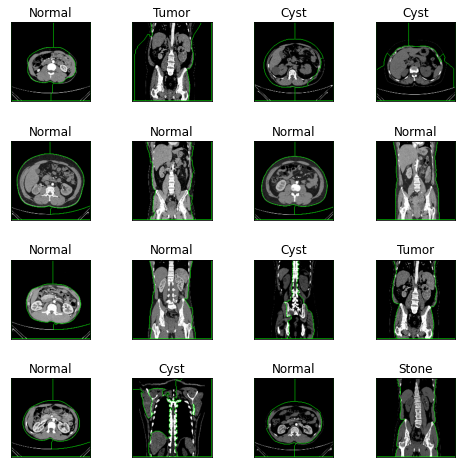

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [18]:
import tensorflow as tf
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.8.2'

In [19]:


# Normalization of data 
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.
test_imgs_scaled = test_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform(test_labels)

train_labels_enc = tf.keras.utils.to_categorical(train_labels_enc, 4)
val_labels_enc = tf.keras.utils.to_categorical(val_labels_enc, 4)
test_labels_enc = tf.keras.utils.to_categorical(test_labels_enc, 4)


# change version of tensorflow
#%tensorflow_version 2.x

print(train_labels[:6], train_labels_enc[:6])

['Cyst' 'Cyst' 'Tumor' 'Normal' 'Normal' 'Tumor'] [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


Labels: ['Cyst', 'Cyst', 'Cyst', 'Cyst', 'Cyst']


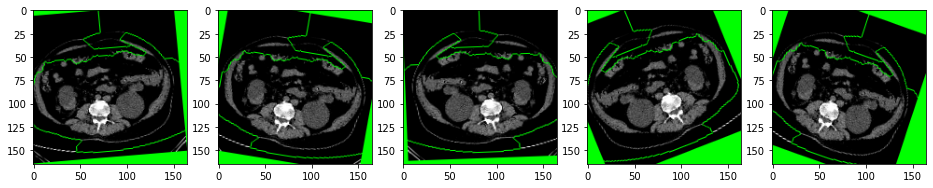

In [20]:
#Applying Data augmentation to images
BATCH_SIZE = 25
NUM_CLASSES = 4
EPOCHS = 25
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]

fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

# CNN

In [21]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(1, 1), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 165, 165, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 165, 165, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856 

Frozen VGG

In [26]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False

base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.4)(hidden1)
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 165, 165, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 165, 165, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 165, 165, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 82, 82, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 82, 82, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 82, 82, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 41, 41, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [27]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


Finetuned VGG

In [28]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

vgg.trainable = False

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1' , 'block4_conv1']:
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.4)(hidden1)
hidden2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 165, 165, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 165, 165, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 165, 165, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 82, 82, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 82, 82, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 82, 82, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 41, 41, 128)       0   

In [29]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


InceptionV3

In [31]:

incept = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
incept.trainable = True

set_trainable = False
for layer in incept.layers:
    if layer.name in ['conv2d_367' , 'conv2d_369','conv2d_375', 'conv2d_86' ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_incept = incept
base_out = base_incept.output
pool_out = tf.keras.layers.Flatten()(base_out)

hidden1 = tf.keras.layers.Dense(256, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.2)(hidden2) 

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)
#sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = tf.keras.Model(inputs=base_incept.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001,momentum=.9,nesterov=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()


87924736/87910968 [==============================] - 1s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 165, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 82, 82, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 82, 82, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                           

In [32]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 317
Total trainable layers: 56


Xception

In [33]:
incept = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
incept.trainable = True

set_trainable = False
for layer in incept.layers:
    if layer.name in ['conv2d_367' , 'conv2d_369','conv2d_375', 'conv2d_86' ]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_incept = incept
base_out = base_incept.output
pool_out = tf.keras.layers.Flatten()(base_out)

hidden1 = tf.keras.layers.Dense(256, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.2)(hidden2) 

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)
#sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = tf.keras.Model(inputs=base_incept.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001,momentum=.9,nesterov=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()


83697664/83683744 [==============================] - 2s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 165, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 82, 82, 32)   864         ['input_8[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 82, 82, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                           

In [34]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 138
Total trainable layers: 6


Resnet

In [35]:
incept = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
incept.trainable = True

set_trainable = False
for layer in incept.layers:
    if layer.name in []:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_incept = incept
base_out = base_incept.output
pool_out = tf.keras.layers.Flatten()(base_out)

hidden1 = tf.keras.layers.Dense(256, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(128, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.2)(hidden2) 

out = tf.keras.layers.Dense(4, activation='softmax')(drop2)
#sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = tf.keras.Model(inputs=base_incept.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.001,momentum=.9,nesterov=False),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 165, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 171, 171, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 83, 83, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

In [36]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 181
Total trainable layers: 6


In [30]:
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/25
314/314 [==============================] - 78s 211ms/step - loss: 0.8548 - accuracy: 0.6568 - val_loss: 0.3903 - val_accuracy: 0.8482
Epoch 2/25
314/314 [==============================] - 66s 209ms/step - loss: 0.3614 - accuracy: 0.8687 - val_loss: 0.1683 - val_accuracy: 0.9376
Epoch 3/25
 26/314 [=>............................] - ETA: 58s - loss: 0.2476 - accuracy: 0.9185

KeyboardInterrupt: ignored

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('KidneyStoneDetector_squeezenet.h5')

In [ ]:
#scale test data
test_imgs_scaled.shape, test_labels_enc.shape

In [ ]:
score = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])